In [31]:
# Standard library imports
import os
import shutil

# Data manipulation and file handling
import numpy as np
import pandas as pd
import h5py

# Image processing libraries
from PIL import Image
import cv2
from skimage import data, img_as_float, exposure, transform

# TensorFlow and Keras for neural networks
import tensorflow as tf

# Model selection tools
from sklearn.model_selection import train_test_split

# PyTorch for deep learning
import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import models as torch_models, transforms

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab

In [32]:
lung_nodule_data = h5py.File('all_patches.hdf5','r')

images = np.array(lung_nodule_data['ct_slices'])
images_class = np.array(lung_nodule_data['slice_class'])

print(images.shape)
print(images_class.shape)

(6691, 64, 64)
(6691, 1)


In [33]:
images = images.reshape(6691,64,64,1)

X_train, X_test, y_train, y_test = train_test_split(images, images_class, test_size=0.33, random_state=42)

y_train = utils.to_categorical(y_train, num_classes=2)
y_test = utils.to_categorical(y_test, num_classes=2)

print(X_train.shape)
print(y_train.shape)

(4482, 64, 64, 1)
(4482, 2)


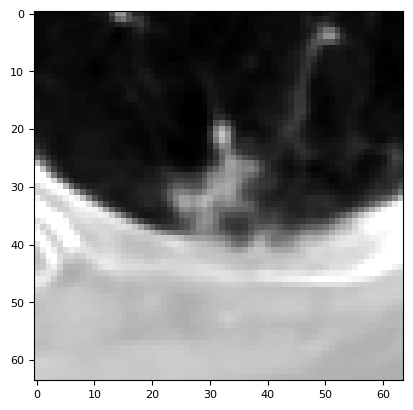

In [34]:
images = np.clip(images, -1000, 320)

pylab.imshow(images[5], cmap=pylab.cm.gray)  
pylab.show()

c:\Users\halmi\Downloads\RedesNeurais\LungCancerDetector\.venv\Lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


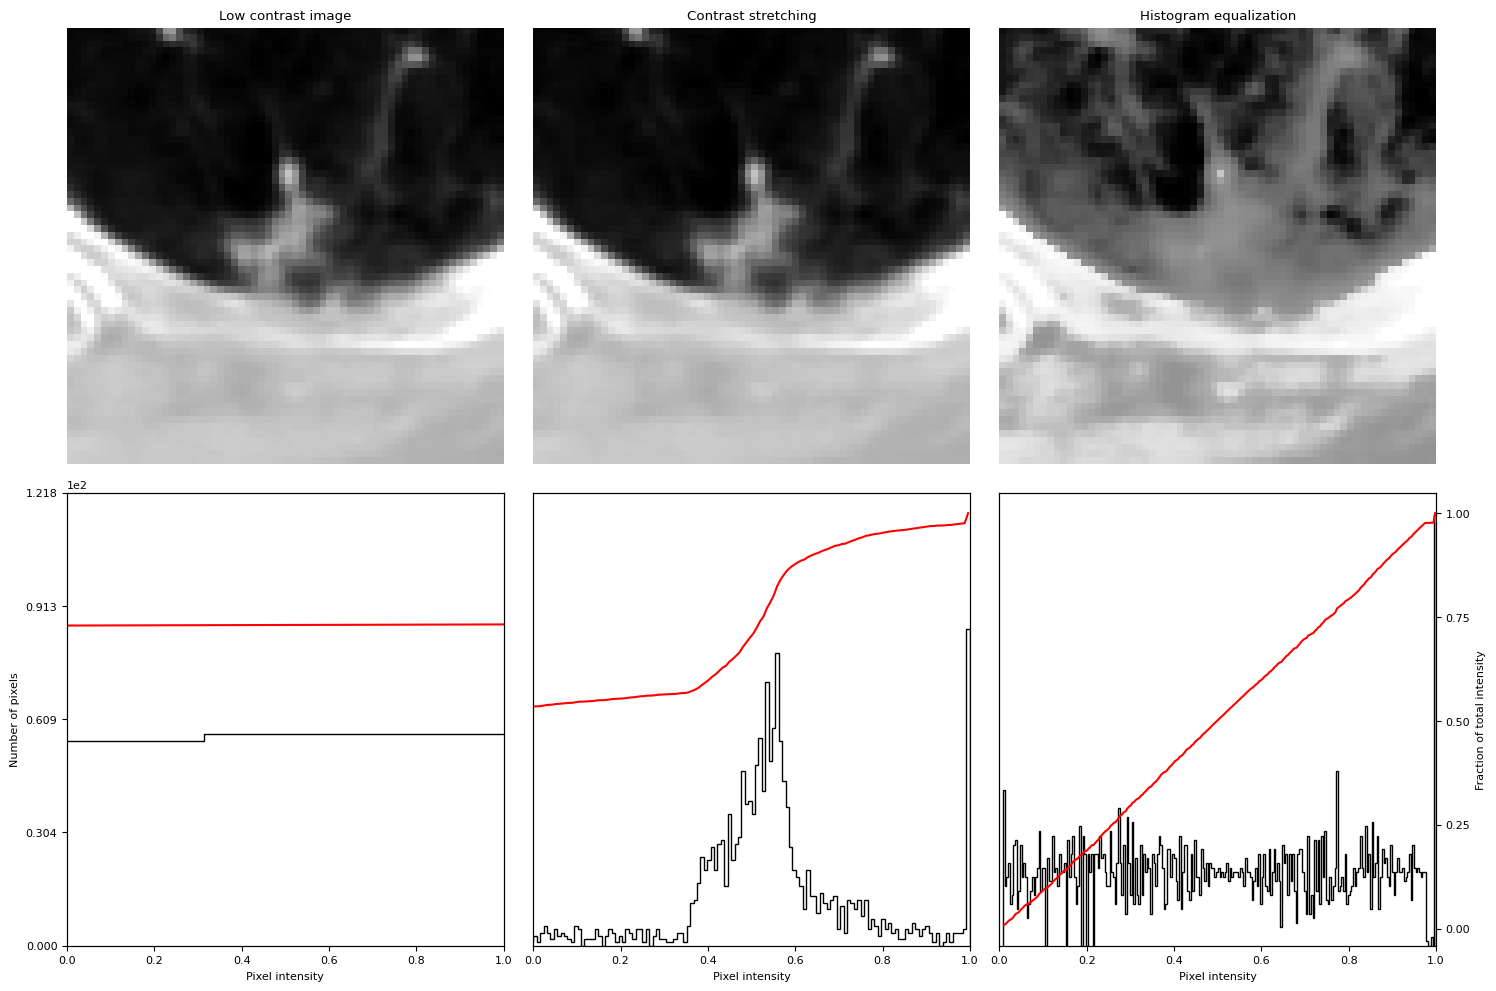

In [35]:
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

# Set font size for images
mpl.rcParams['font.size'] = 8

img = images[5]

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Histogram Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
# img_adapteq = exposure.equalize_adapthist(img)

#### Everything below here is just to create the plot/graphs ####

# Display results
fig = plt.figure(figsize=(15, 10)) 
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = fig.add_subplot(2, 3, 1)
for i in range(1, 3):
    axes[0, i] = fig.add_subplot(2, 3, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 3):
    axes[1, i] = fig.add_subplot(2, 3, 4+i)
    
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

# ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
# ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [36]:
model = tf.keras.models.Sequential()


model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(64,64,1)))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
history = model.fit(
        X_train,y_train,
        batch_size=100,
        epochs=100,
        validation_data=(X_test, y_test))

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.5447 - loss: 10.2624 - val_accuracy: 0.6157 - val_loss: 0.7030
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.6270 - loss: 0.6519 - val_accuracy: 0.6555 - val_loss: 0.6241
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.6716 - loss: 0.6173 - val_accuracy: 0.6732 - val_loss: 0.6218
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.6842 - loss: 0.6036 - val_accuracy: 0.6600 - val_loss: 0.6105
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 366ms/step - accuracy: 0.6974 - loss: 0.5884 - val_accuracy: 0.6917 - val_loss: 0.5789
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.7162 - loss: 0.5599 - val_accuracy: 0.7288 - val_loss: 0.5585
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 364ms/step - accuracy: 0.7325 - loss: 0.5418 - val_accuracy: 0.7370 - val_loss: 0.5420
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 373ms/step - accuracy: 0.7409 - loss: 0.5184 -